In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
from matplotlib.colors import ListedColormap
import copy

### Remove extraneous columns from the promoter / peak intersect file

In [113]:
# promoterintersectfilename = '/nfs/lab/jnewsome/pbmc/peaks_intersect_promoters.HIGHSPECFILTER.bed'
# reducecolfilename = '/nfs/lab/jnewsome/pbmc/peaks_intersect_promoters.HIGHSPECFILTER.lesscol.bed'

# promfile = open(promoterintersectfilename)
# reducecolfile = open(reducecolfilename, 'w')
# for line in promfile:
#     line = line.strip()
#     if len(line) > 0:
#         s = line.split()
#         chrom = s[0]
#         start = s[1]
#         end = s[2]
#         gene = s[7]
#         outline = chrom + '\t' + start + '\t' + end + '\t' + gene + '\n'
#         reducecolfile.write(outline)
# promfile.close()
# reducecolfile.close()
# #   0       1        2           3         4         5       6       7
# # chr1    1265807 1266809 mem_b,plasma    chr1    1266194 1267194 TAS1R3
# # chr1    1293848 1294360 naive_cd4_t,cMono,naive_cd8_t,act_cd4_t,cDC,cyto_nk,ncMono,iMono     chr1     1293415 1294415 MXRA8


### Inputs

In [212]:
indir = '/nfs/lab/jnewsome/pbmc/highSpecIntersect/'
broadPops_wPlasma = ['b', 'mono', 'cd4_t_AND_cd8_t', 'nk', 'cd4_t', 
             'pDC', 'cd8_t', 'mkc', 'plasma',  ]
broadPops = ['b', 'mono', 'cd4_t_AND_cd8_t', 'nk', 'cd4_t', 
             'pDC', 'cd8_t', 'mkc',  ]

finePops = ['act_cd4_t', 'mem_b',  'adaptive_NK', 'mem_cd8_t', 
            'cDC', 'mkc', 'naive_b', 'naive_cd4_t',
             'cyto_cd8_t', 'naive_cd8_t', 'ncMono',  'cMono',  
            'cyto_nk', 'pDC', 'plasma',  'iMono',  'tReg']


geneList = ['AC233755.1', 'COL19A1', 'C1QC', 'MERTK', 'C2', 'COX6A2', 
            'ZMAT4', 'APOC2', 'LRRC26', 'TPM2', 'FANK1', 'CTLA4', 
            'S1PR3', 'RXFP2', 'KRT7', 'L1TD1', 'CTTNBP2', 'TAS1R3', 
            'APOD', 'KCNG1', 'APBB2', 'ADAM23', 'CFAP97D2', 'MXRA8', 
            'SEMA3G', 'ACTG2']

inprefix = '/nfs/lab/jnewsome/pbmc/highSpecIntersect/pbmc1-15.'
insuffix = '.highSpecGeneIntersect.1promPeakIntersect.tagAlign'
barcodeFileName = '/nfs/lab/jnewsome/pbmc/pbmc1-15.barcodeClusterNames.FINAL.AllCellTypes.txt'




cellTypesDict_colors_broad = {
    'cd4_t' :  '255,0,255', # magenta
    'mono' :  '127,201,127', # green 
    'cd8_t' : '0,231,244', #blue 
    'nk' :  '139,90,43', # tan4
    'b' :  '238,154,0', # orange
    'mkc' :  '170,110,40',  # brown
    'plasma' :  '75,0,130', #indigo
    'pDC' :  '81,54,26',  # dark brown
    't' : '139,0,139',  # dark brown
    'cd4_t_AND_cd8_t' : '221,160,221',
}


cellTypesDict_colors = {
    'act_cd4_t' : '247,129,191',
    'naive_cd4_t' :  '231,41,138', 
    'tReg' :  '255,0,0', 
    'ncMono' :  '166,216,84',
    'iMono' : '0,139,0', 
    'cMono' :  '180,238,180',  
    'cDC' :  '0,139,139', 
    'cyto_cd8_t' : '31,120,180',
    'naive_cd8_t' : '179,205,227',
    'mem_cd8_t' :  '0,178,238',
    'cyto_nk' :  '166,86,40',
    'adaptive_NK' :  '241,226,204', 
    'naive_b' :  '253,192,134', 
    'mem_b' :  '255,127,0', 
    'mkc' :  '188,128,189', 
    'plasma' :  '255,215,0', 
    'pDC' :  '179,179,179', 
}


broadFineColors = {
    'cd4_t' :  '255,0,255', # magenta
    'mono' :  '127,201,127', # green 
    'cd8_t' : '0,231,244', #blue 
    'nk' :  '139,90,43', # tan4
    'b' :  '238,154,0', # orange
    't'  : '221,160,221',
    'act_cd4_t' : '247,129,191',
    'naive_cd4_t' :  '231,41,138', 
    'tReg' :  '255,0,0', 
    'ncMono' :  '166,216,84',
    'iMono' : '0,139,0', 
    'cMono' :  '180,238,180',  
    'cDC' :  '0,139,139', 
    'cyto_cd8_t' : '31,120,180',
    'naive_cd8_t' : '179,205,227',
    'mem_cd8_t' :  '0,178,238',
    'cyto_nk' :  '166,86,40',
    'adaptive_NK' :  '241,226,204', 
    'naive_b' :  '253,192,134', 
    'mem_b' :  '255,127,0', 
    'mkc' :  '188,128,189', 
    'plasma' :  '255,215,0', 
    'pDC' :  '179,179,179',     
    
}



fine_color_scaled = {}
for c in cellTypesDict_colors.keys():
    col = cellTypesDict_colors[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    fine_color_scaled[c] = (r, g, b)
    
broad_color_scaled = {}
for c in cellTypesDict_colors_broad.keys():
    col = cellTypesDict_colors_broad[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    broad_color_scaled[c] = (r, g, b)

broadfine_color_scaled = {}
for c in broadFineColors.keys():
    col = broadFineColors[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    broadfine_color_scaled[c] = (r, g, b)


geneTitleDict = {
    'COL19A1': 'COL19A1: B Cells', # COL19A1
    'C1QC':  'C1QC: Monocytes', # C1QC
   'MERTK':  'MERTK: Monocytes', # MERTK
    'C2':  'C2: Monocytes', # C2
   'COX6A2':  'COX6A2: NK Cells', # COX6A2
    'ZMAT4':  'ZMAT4: NK Cells', # ZMAT4
    'APOC2':  'APOC2: NK Cells', # APOC2
    'LRRC26':  'LRRC26: pDCs', # LRRC26
   'TPM2':  'TPM2: pDCs', # TPM2
   'FANK1':  'FANK1: T-Cells', # FANK1
   'CTLA4':  'CTLA4: T-Cells', # CTLA4
 'S1PR3':  'S1PR3: Classical Monocytes', # S1PR3
   'RXFP2':  'RXFP2: Classical Monocytes', # RXFP2
   'KRT7':  'KRT7: Intermediate Monocytes', # KRT7
   'L1TD1':  'L1TD1: Non-Classical Monocytes', # L1TD1
   'CTTNBP2': 'CTTNBP2: Non-Classical Monocytes', # CTTNBP2
  'TAS1R3':  'TAS1R3: Memory B Cells', # TAS1R3
  'APOD':  'APOD: Memory B Cells', # APOD
   'KCNG1':  'KCNG1: Naive B Cells', # KCNG1
    'APBB2':  'APBB2: Naive B Cells', # APBB2
 'ADAM23': 'ADAM23: Memory CD4+ T-cells', # ADAM23
   'CFAP97D2':  'CFAP97D2: Naive CD8+ T-cells',
   'MXRA8':  'MXRA8: Naive CD8+ T-cells', # MXRA8
  'SEMA3G':  'SEMA3G: Regulatory CD4+ T-cells', # SEMA3G
  'ACTG2': 'ACTG2: Regulatory CD4+ T-cells', # ACTG2
}



### Read prom intersected tagalign file to gene --> pop ---> [barcode] dict

In [115]:
dict1 = {}
for gene in geneList:
    dict1[gene] = {}
    dict1[gene]['broadPops'] = {}
    dict1[gene]['finePops'] = {}
    for pop in broadPops:
        dict1[gene]['broadPops'][pop] = defaultdict(int)
    for pop in finePops:
        dict1[gene]['finePops'][pop] = defaultdict(int)

for pop in broadPops_wPlasma:
    print(pop)
    tagfilename = inprefix + pop + insuffix
    if pop == 'plasma':
        pop = 'b'
    tagfile = open(tagfilename)
    for line in tagfile:
        line = line.strip()
        # chr1	1266484	1266684	pbmc8_CTCTACGCAATACTGC	60	-	chr1	1266683	1266704	TAS1R3
        #  0     1        2            3                4   5    6        7        8      9
        s = line.split()
        bar = s[3]
        gene = s[9]
        dict1[gene]['broadPops'][pop][bar] += 1  
print('done!')        

for pop in finePops:
    print(pop)
    tagfilename = inprefix + pop + insuffix
    tagfile = open(tagfilename)
    for line in tagfile:
        line = line.strip()
        s = line.split()
        bar = s[3]
        gene = s[9]
        dict1[gene]['finePops'][pop][bar] += 1
            
print('done!')        

b
mono
cd4_t_AND_cd8_t
nk
cd4_t
pDC
cd8_t
mkc
plasma
done!
act_cd4_t
mem_b
adaptive_NK
mem_cd8_t
cDC
mkc
naive_b
naive_cd4_t
cyto_cd8_t
naive_cd8_t
ncMono
cMono
cyto_nk
pDC
plasma
iMono
tReg
done!


### Read total barcodes from barcode file

In [116]:
barDict = {}
barDict['finePops'] = {}
barDict['broadPops'] = {}
for pop in broadPops:
    barDict['broadPops'][pop] = list()
    
for pop in finePops:
    barDict['finePops'][pop] = list()
    

barfile = open(barcodeFileName)
for line in barfile:
    line = line.strip()
    if not line.startswith('sample'):
        s = line.split()
        bar = s[0]
        broadPop = s[5]
        finePop = s[4]
        
        if broadPop == 'plasma':
            broadPop = 'b'
        
        
        barDict['finePops'][finePop].append(bar)
        barDict['broadPops'][broadPop].append(bar)

# sample	leiden	subcluster	fine_populations	broad_populations	fine_populations_long	broad_populations_long	UMAP1	UMAP2	unique_usable_reads	total_sequenced_reads	duplicated_reads	unique_mito_reads	reads_in_peaks	reads_in_promoters	tss_used	frac_reads_in_peaks	frac_reads_in_promoters	frac_promoters_used	frac_mito_reads	frac_duplicated_reads	log10_unique_usable_reads	n_counts	log10_usable_counts	norm
#   0         1        2          4       
# pbmc1_AAACGAAAGAAAGGGT	pbmc1	5	5,17	cyto_nk	nk	Cytotoxic NK Cells	NK Cells	16.3818	4.42573	18920	27626	8419	146	13178	7862	3114	0.6965116279069767	0.4155391120507399	0.160963506668045	0.0076576104059582	0.3047491493520596	4.27694408571298219042.0	3.450249195098877	0
#    0                       1      2    3       4 
barfile.close()

In [117]:
######################## double check populations in barcodes file
# uniquePopDict_broad = {}
# uniquePopDict_fine = {}
# barfile = open(barcodeFileName)
# for line in barfile:
    
#     line = line.strip()
#     if not line.startswith('sample'):
#         s = line.split()
#         broadPop = s[5]
#         finePop = s[4]
# #         print(broadPop, finePop)
#         uniquePopDict_broad[broadPop] = broadPop
#         uniquePopDict_fine[finePop] = finePop
# barfile.close()

In [118]:
# uniquePopDict_broad['plasma']

# uniquePopDict_fine.keys()

# for pop in barDict['finePops'].keys():
#     print(pop, len(barDict['finePops'][pop]))
# len(barDict['broadPops'])

In [124]:
geneList = ['COL19A1', 'C1QC', 'MERTK', 'C2', 'COX6A2', 
            'ZMAT4', 'APOC2', 'LRRC26', 'TPM2', 'FANK1', 'CTLA4', 
            'S1PR3', 'RXFP2', 'KRT7', 'L1TD1', 'CTTNBP2', 'TAS1R3', 
            'APOD', 'KCNG1', 'APBB2', 'ADAM23', 'MXRA8', 
            'SEMA3G', 'ACTG2']

In [125]:
colList = ['Cell_Type']
colList = colList + geneList
broad = pd.DataFrame(columns = geneList)
fine = pd.DataFrame(columns = geneList)

for pop in broadPops:
    addColDict = {}
    addColDict['Cell_Type'] = pop
    if pop == 'cd4_t_AND_cd8_t':
        totalCount = len(barDict['broadPops']['cd4_t']) + len(barDict['broadPops']['cd8_t'])
    else:
        totalCount = len(barDict['broadPops'][pop])
    for gene in geneList:
        count = len(dict1[gene]['broadPops'][pop].keys())
        prop = count / totalCount
        addColDict[gene] = prop
    broad = broad.append(addColDict, 
                    ignore_index = True)

for pop in finePops:
    addColDict = {}
    addColDict['Cell_Type'] = pop    
    if pop == 'cd4_t_AND_cd8_t':
        totalCount = len(barDict['finePops']['cd4_t']) + len(barDict['finePops']['cd8_t'])
#         print('cd4_t_AND_cd8_t')
    else:
        totalCount = len(barDict['finePops'][pop])
        
    for gene in geneList:
        count = len(dict1[gene]['finePops'][pop].keys())
#         print('pop = ', pop, 'gene = ', gene, 'totalCount = ', totalCount, 'count = ', count)
        prop = count / totalCount
        addColDict[gene] = prop
    fine = fine.append(addColDict, 
                    ignore_index = True)
    
broad.index = broad['Cell_Type']
fine.index = fine['Cell_Type']
# broad = broad.drop(['Cell_Type'], axis = 1)
# fine = fine.drop(['Cell_Type'], axis = 1)
broad = broad.drop(['Cell_Type'], axis = 1)

In [126]:
newRowOrderFine = [ 'mem_b', 'naive_b', 'plasma',  
                    'adaptive_NK', 'cyto_nk', 
                    'act_cd4_t', 'naive_cd4_t', 'tReg', 
                    'mem_cd8_t',  'cyto_cd8_t', 'naive_cd8_t', 
                    'ncMono',  'cMono',   'iMono', 'cDC',
                    'mkc', 'pDC',  ]
fine = fine.reindex(newRowOrderFine)

newRowOrderBroad = ['b', 'nk', 'mono',
                    'cd4_t_AND_cd8_t', 'cd4_t', 'cd8_t',
                     'mkc', 'pDC',  ]
broad = broad.reindex(newRowOrderBroad)

In [163]:
broadLabel = ['b', 'nk', 'mono',
                    't', 'cd4_t', 'cd8_t',
                     'mkc', 'pDC',  ]

In [127]:
broad

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,L1TD1,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2
Cell_Type,,,,,,,,,,,,,,,,,,,,,
b,0.293018,0.0,0.061941,0.142304,0.006007,0.000534,0.000801,0.019090,0.031771,0.081298,...,0.001335,0.002803,0.008010,0.0,0.044854,0.088373,0.051128,0.003738,0.065278,0.0
nk,0.052393,0.0,0.080490,0.183585,0.054611,0.024823,0.008345,0.009718,0.056195,0.130348,...,0.000951,0.001162,0.002958,0.0,0.021971,0.013732,0.005070,0.006232,0.065808,0.0
mono,0.033897,0.0,0.092975,0.119770,0.016400,0.000549,0.007942,0.006650,0.063598,0.126227,...,0.014560,0.026795,0.002905,0.0,0.017853,0.106696,0.015205,0.010105,0.079449,0.0
cd4_t_AND_cd8_t,0.102195,0.0,0.066312,0.200288,0.017501,0.000752,0.001267,0.015912,0.038782,0.061136,...,0.001396,0.002835,0.002770,0.0,0.008912,0.031030,0.028968,0.007623,0.074987,0.0
cd4_t,0.105160,0.0,0.070017,0.204609,0.012199,0.000845,0.001217,0.016186,0.037948,0.059980,...,0.001521,0.002805,0.002467,0.0,0.009225,0.035380,0.040077,0.007536,0.078262,0.0
cd8_t,0.097025,0.0,0.059853,0.192754,0.026745,0.000589,0.001355,0.015434,0.040236,0.063152,...,0.001178,0.002887,0.003299,0.0,0.008365,0.023446,0.009602,0.007776,0.069278,0.0
mkc,0.015179,0.0,0.014286,0.116071,0.010714,0.000893,0.007143,0.004464,0.033929,0.067857,...,0.000893,0.003571,0.000000,0.0,0.000893,0.017857,0.003571,0.000893,0.009821,0.0
pDC,0.065789,0.0,0.084211,0.150000,0.015789,0.000000,0.002632,0.076316,0.107895,0.110526,...,0.000000,0.023684,0.002632,0.0,0.018421,0.152632,0.015789,0.013158,0.068421,0.0


In [128]:
fine

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2,Cell_Type
Cell_Type,,,,,,,,,,,,,,,,,,,,,
mem_b,0.301668,0.0,0.063485,0.188137,0.005097,0.000927,0.001390,0.018999,0.028730,0.087118,...,0.006951,0.020389,0.0,0.015292,0.063485,0.020853,0.003244,0.084337,0.0,mem_b
naive_b,0.289392,0.0,0.059427,0.120790,0.006581,0.000387,0.000581,0.018389,0.032520,0.076461,...,0.000968,0.001936,0.0,0.056911,0.098529,0.063879,0.003871,0.054781,0.0,naive_b
plasma,0.293413,0.0,0.119760,0.215569,0.000000,0.000000,0.000000,0.041916,0.047904,0.155689,...,0.005988,0.035928,0.0,0.053892,0.095808,0.047904,0.005988,0.143713,0.0,plasma
adaptive_NK,0.056625,0.0,0.140430,0.168743,0.061155,0.063420,0.028313,0.013590,0.058890,0.142695,...,0.005663,0.003398,0.0,0.010193,0.027180,0.006795,0.010193,0.050963,0.0,adaptive_NK
cyto_nk,0.051957,0.0,0.074324,0.185112,0.053938,0.020853,0.006291,0.009320,0.055918,0.129077,...,0.000699,0.002912,0.0,0.023183,0.012349,0.004893,0.005825,0.067335,0.0,cyto_nk
act_cd4_t,0.117917,0.0,0.076610,0.228476,0.014070,0.000581,0.001097,0.018652,0.044211,0.062605,...,0.002453,0.002259,0.0,0.012650,0.029173,0.054989,0.007809,0.087518,0.0,act_cd4_t
naive_cd4_t,0.098458,0.0,0.064777,0.173406,0.010588,0.000834,0.001334,0.014589,0.033264,0.057691,...,0.002918,0.002751,0.0,0.004752,0.046686,0.025677,0.007170,0.058608,0.0,naive_cd4_t
tReg,0.049430,0.0,0.051331,0.206749,0.007605,0.002852,0.001426,0.007129,0.018536,0.053707,...,0.004753,0.002376,0.0,0.009506,0.016635,0.012357,0.007605,0.122148,0.0,tReg
mem_cd8_t,0.082999,0.0,0.070970,0.192462,0.036488,0.000000,0.002005,0.015237,0.056536,0.090617,...,0.003208,0.004411,0.0,0.007618,0.004812,0.006816,0.004010,0.068565,0.0,mem_cd8_t


In [159]:
# # plot1 = fine.plot.bar(x="Cell_Type", y="COL19A1", c = cellTypesDict_colors,
# #         width = 0.4)

# plt.bar(x="Cell_Type", y="COL19A1", c = cellTypesDict_colors,
#         width = 0.4, height = 0.4)
# # df.plot(x="Cell_Type", y=["COL19A1"])
# plt.show()

SyntaxError: invalid syntax (4081878078.py, line 1)

In [204]:

def setFinePopSubFig (geneName):
    plot1 = sns.barplot(x = 'Cell_Type',
            y = geneName,
            data = fine, palette=fine_color_scaled, )


    sns.set(font_scale = 1)
    # plot1.set_yticklabels( size = 10)
    plot1.set_xticklabels(fine.index, size = 10,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Sub-type", fontsize = 20)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 20)
    plot1.set_title(geneName, fontsize = 20)
    return plot1


def setBroadPopSubFig (geneName):
    plot1 = sns.barplot(x = broad.index,
            y = geneName,
            data = broad, palette=broad_color_scaled, )
    # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
    plot1.set_xticklabels(broadLabel, size = 12,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Type", fontsize = 15)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 15)
    plot1.set_title(geneName, fontsize = 20)
    return plot1


def setBroadFinePopSubFig (geneName, plotTitle):
    plot1 = sns.barplot(x = broadfine.index,
            y = geneName,
            data = broadfine, palette=broadfine_color_scaled, )
    # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
    plot1.set_xticklabels(plot1.get_xticklabels(), size = 12,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Type", fontsize = 15)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 15)
    plot1.set_title(plotTitle, fontsize = 20)
    return plot1





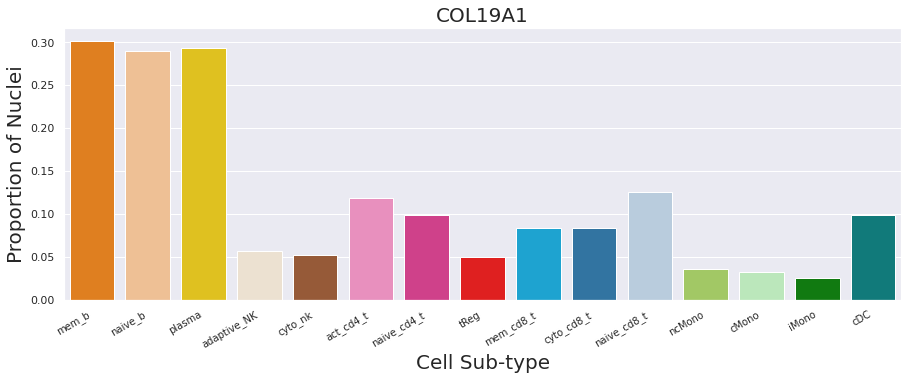

In [199]:
sns.set(font_scale = 1)
plotA = setFinePopSubFig ("COL19A1")
plt.gcf().set_size_inches(15, 5)
plt.show()

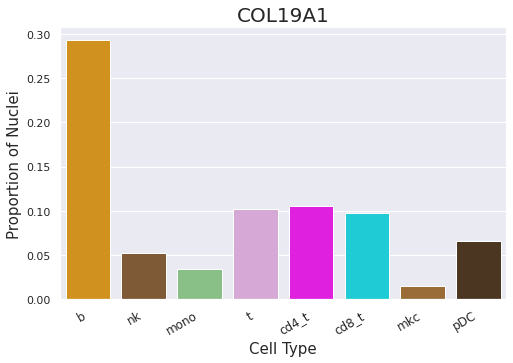

In [200]:
sns.set(font_scale = 1)
plotB = setBroadPopSubFig ('COL19A1')
plt.gcf().set_size_inches(8, 5)
plt.show()

In [202]:
broadfine = copy.deepcopy(broad)
broadfine = broadfine.append(fine)
broadfine = broadfine.drop(index='cd4_t')
broadfine = broadfine.drop(index='cd8_t')
indlist = list(broadfine.index.values)
indlist2 = list()
for ind in indlist:
    if ind == 'cd4_t_AND_cd8_t':
        ind = 't'
    indlist2.append(ind)

broadfine.index = indlist2

broadfine

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2,Cell_Type
b,0.293018,0.0,0.061941,0.142304,0.006007,0.000534,0.000801,0.019090,0.031771,0.081298,...,0.002803,0.008010,0.0,0.044854,0.088373,0.051128,0.003738,0.065278,0.0,NaN
nk,0.052393,0.0,0.080490,0.183585,0.054611,0.024823,0.008345,0.009718,0.056195,0.130348,...,0.001162,0.002958,0.0,0.021971,0.013732,0.005070,0.006232,0.065808,0.0,NaN
mono,0.033897,0.0,0.092975,0.119770,0.016400,0.000549,0.007942,0.006650,0.063598,0.126227,...,0.026795,0.002905,0.0,0.017853,0.106696,0.015205,0.010105,0.079449,0.0,NaN
t,0.102195,0.0,0.066312,0.200288,0.017501,0.000752,0.001267,0.015912,0.038782,0.061136,...,0.002835,0.002770,0.0,0.008912,0.031030,0.028968,0.007623,0.074987,0.0,NaN
mkc,0.015179,0.0,0.014286,0.116071,0.010714,0.000893,0.007143,0.004464,0.033929,0.067857,...,0.003571,0.000000,0.0,0.000893,0.017857,0.003571,0.000893,0.009821,0.0,NaN
pDC,0.065789,0.0,0.084211,0.150000,0.015789,0.000000,0.002632,0.076316,0.107895,0.110526,...,0.023684,0.002632,0.0,0.018421,0.152632,0.015789,0.013158,0.068421,0.0,NaN
mem_b,0.301668,0.0,0.063485,0.188137,0.005097,0.000927,0.001390,0.018999,0.028730,0.087118,...,0.006951,0.020389,0.0,0.015292,0.063485,0.020853,0.003244,0.084337,0.0,mem_b
naive_b,0.289392,0.0,0.059427,0.120790,0.006581,0.000387,0.000581,0.018389,0.032520,0.076461,...,0.000968,0.001936,0.0,0.056911,0.098529,0.063879,0.003871,0.054781,0.0,naive_b
plasma,0.293413,0.0,0.119760,0.215569,0.000000,0.000000,0.000000,0.041916,0.047904,0.155689,...,0.005988,0.035928,0.0,0.053892,0.095808,0.047904,0.005988,0.143713,0.0,plasma
adaptive_NK,0.056625,0.0,0.140430,0.168743,0.061155,0.063420,0.028313,0.013590,0.058890,0.142695,...,0.005663,0.003398,0.0,0.010193,0.027180,0.006795,0.010193,0.050963,0.0,adaptive_NK


In [211]:
broadfine = broadfine.drop('C1QC', axis = 1)
broadfine = broadfine.drop('ACTG2', axis = 1)

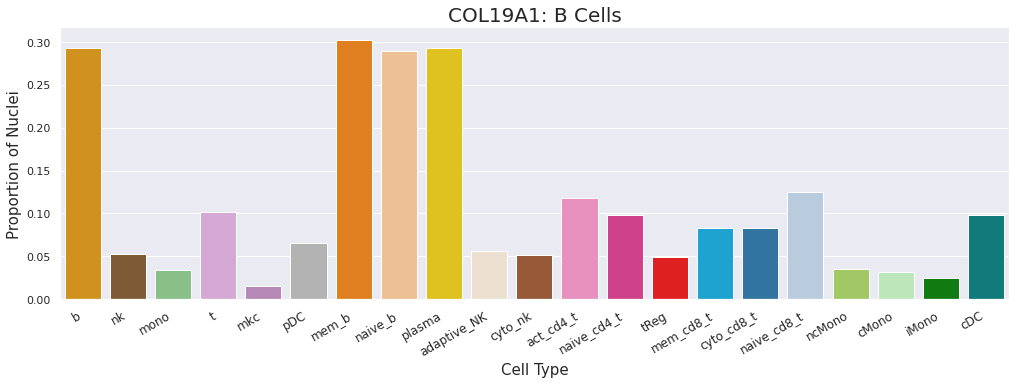

In [206]:
sns.set(font_scale = 1)
plotB = setBroadFinePopSubFig ('COL19A1', 'COL19A1: B Cells')
plt.gcf().set_size_inches(17, 5)
plt.show()

In [220]:

# def setBroadFinePopSubFig_subplot (geneName, plotTitle, axN):
#     ax[axN] = sns.barplot(x = broadfine.index,
#             y = geneName, ax=ax[axN],
#             data = broadfine, palette=broadfine_color_scaled, )
#     # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
#     ax[axN].set_xticklabels(plot1.get_xticklabels(), size = 12,rotation = 30, ha='right')
#     ax[axN].set_xlabel("Cell Type", fontsize = 15)
#     ax[axN].set_ylabel("Proportion of Nuclei", fontsize = 15)
#     ax[axN].set_title(plotTitle, fontsize = 20)



In [257]:
broadfine = broadfine.drop('Cell_Type', axis = 1)
genes = list(broadfine.columns)

<Figure size 1152x576 with 0 Axes>

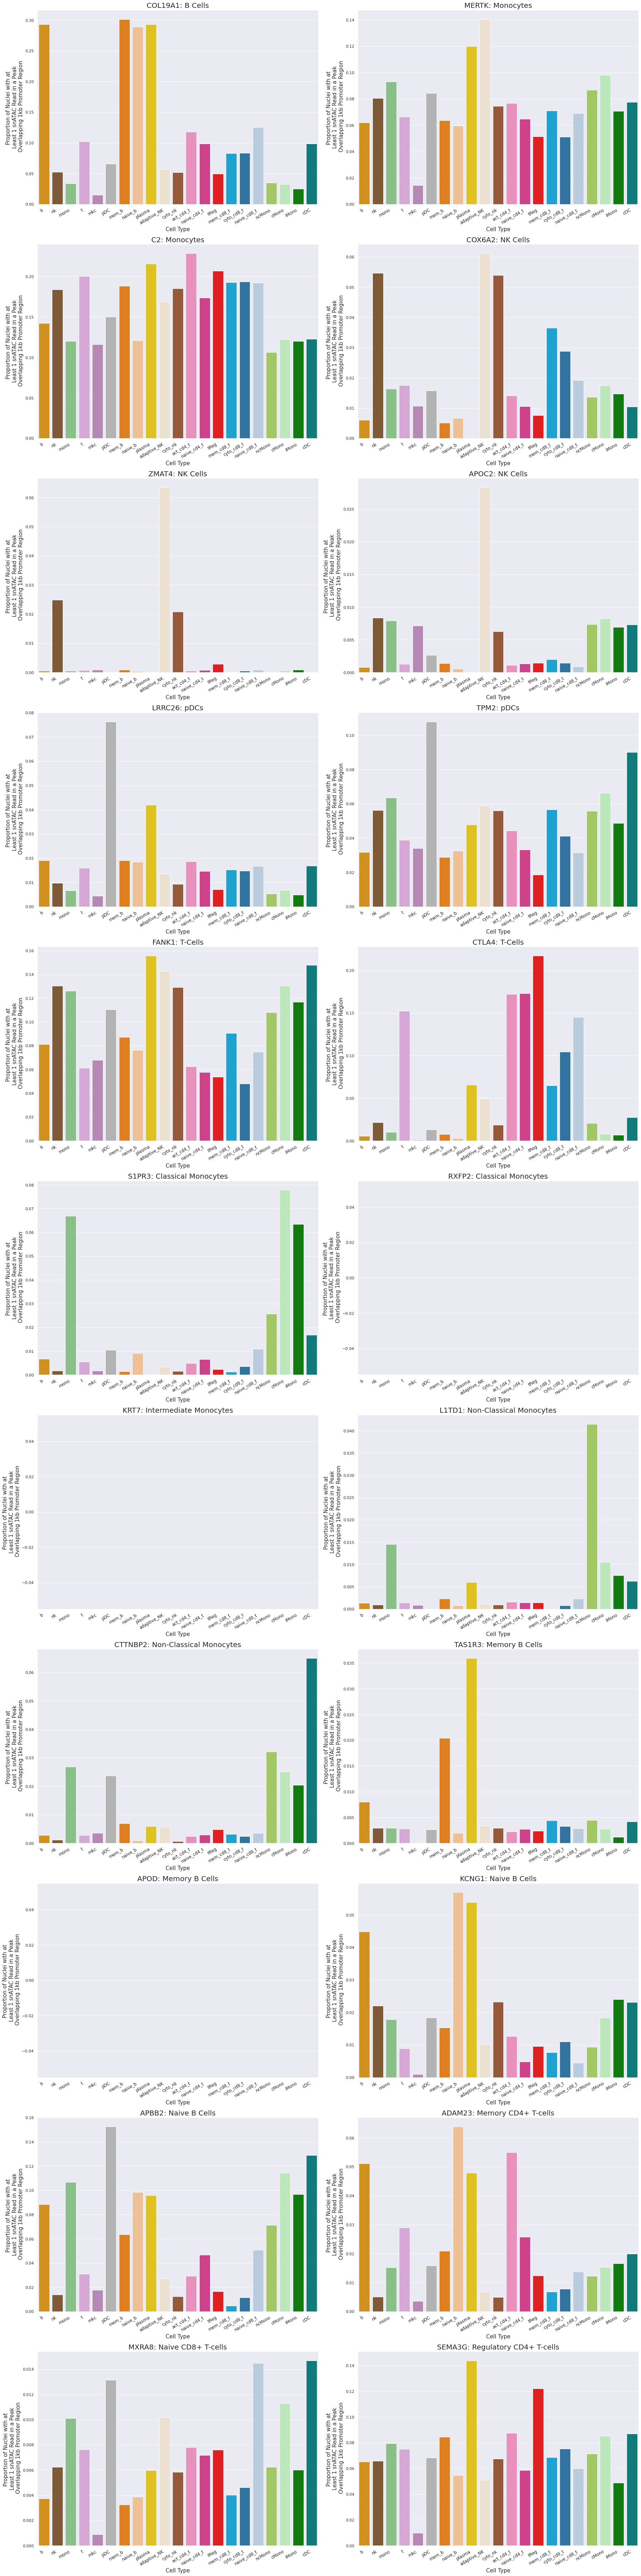

In [273]:
plt.figure(figsize=(16, 8)) 
sns.set(font_scale = 1)
# plt.gcf().set_size_inches(17, 5)
fig, axes = plt.subplots(11,2,figsize=(16, 8))
# ax = ax.flatten()
# fig.set_size_inches(17, 5)
fig.set_figheight(100)
fig.set_figwidth(25)
for gene, ax in zip(list(broadfine.columns), axes.flatten()):
#     print(gene)
    sns.barplot(x = broadfine.index, y = gene, ax=ax,
            data = broadfine, palette=broadfine_color_scaled, )
    ax.set_xticklabels(ax.get_xticklabels(), size = 12,rotation = 30, ha='right')
    ax.set_xlabel("Cell Type", fontsize = 15)
    ax.set_ylabel("Proportion of Nuclei with at \n Least 1 snATAC Read in a Peak \n Overlapping 1kb Promoter Region", fontsize = 15)
    ax.set_title(geneTitleDict[gene], fontsize = 20)
plt.tight_layout()

In [276]:
broadfine = broadfine.drop('RXFP2', axis = 1)
broadfine = broadfine.drop('KRT7', axis = 1)
broadfine = broadfine.drop('APOD', axis = 1)

<Figure size 1152x576 with 0 Axes>

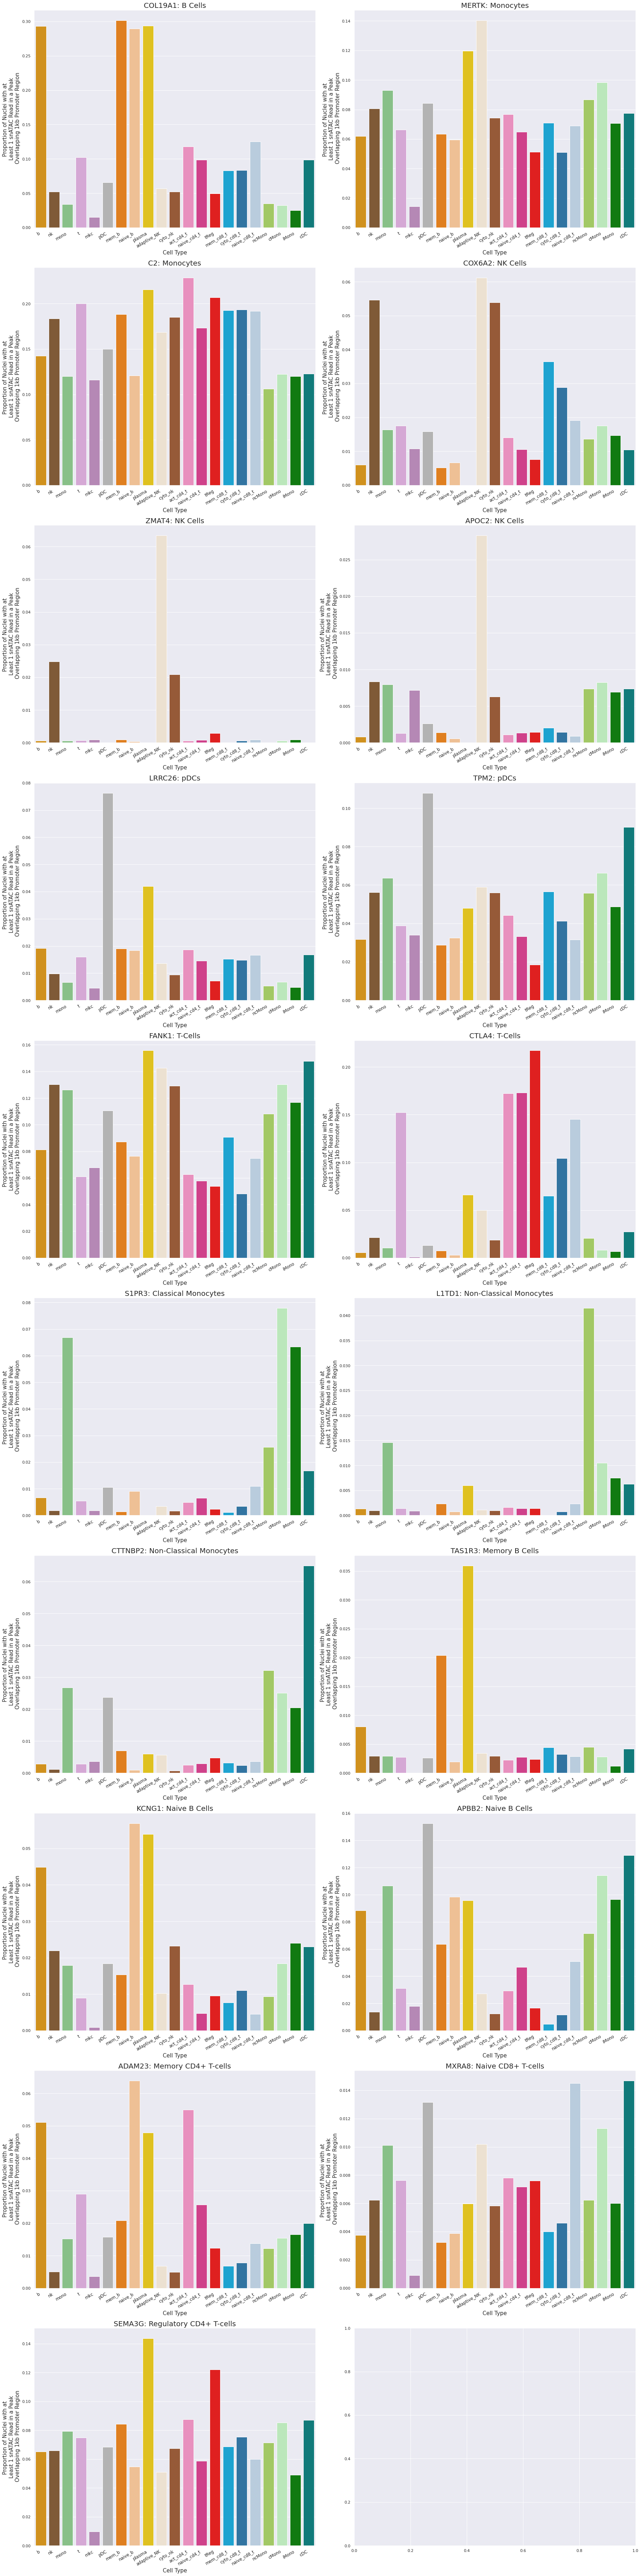

In [278]:
plt.figure(figsize=(16, 8)) 
sns.set(font_scale = 1)
# plt.gcf().set_size_inches(17, 5)
fig, axes = plt.subplots(10,2,figsize=(16, 8))
# ax = ax.flatten()
# fig.set_size_inches(17, 5)
fig.set_figheight(100)
fig.set_figwidth(25)
for gene, ax in zip(list(broadfine.columns), axes.flatten()):
#     print(gene)
    sns.barplot(x = broadfine.index, y = gene, ax=ax,
            data = broadfine, palette=broadfine_color_scaled, )
    ax.set_xticklabels(ax.get_xticklabels(), size = 12,rotation = 30, ha='right')
    ax.set_xlabel("Cell Type", fontsize = 15)
    ax.set_ylabel("Proportion of Nuclei with at \n Least 1 snATAC Read in a Peak \n Overlapping 1kb Promoter Region", fontsize = 15)
    ax.set_title(geneTitleDict[gene], fontsize = 20)
plt.tight_layout()